# SoC final Project: Stock Market Prediction using LSTM

Starting of I imported all the libraries which were required.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns


Fetching the input data from the user regarding the ticker, the starting and end date and the timeframe.

Also downloading the data based on this user input.

In [2]:
ticker = input("Enter the ticker symbol: ")
start_date = input("Enter the start date (YYYY-MM-DD): ")
end_date = input("Enter the end date (YYYY-MM-DD): ")
timeframe = input("Enter the timeframe (e.g., 1d, 1wk, 1mo): ")
data = yf.download(ticker, start=start_date, end=end_date, interval=timeframe)

C:\Users\Dell\AppData\Local\Temp\ipykernel_848\710017323.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, interval=timeframe)
[*********************100%***********************]  1 of 1 completed


Data visualisation using matplotlib and the seaborn libraries.

In [3]:
def plot_data(data):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Close Price')
    plt.title(f'{ticker} Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()


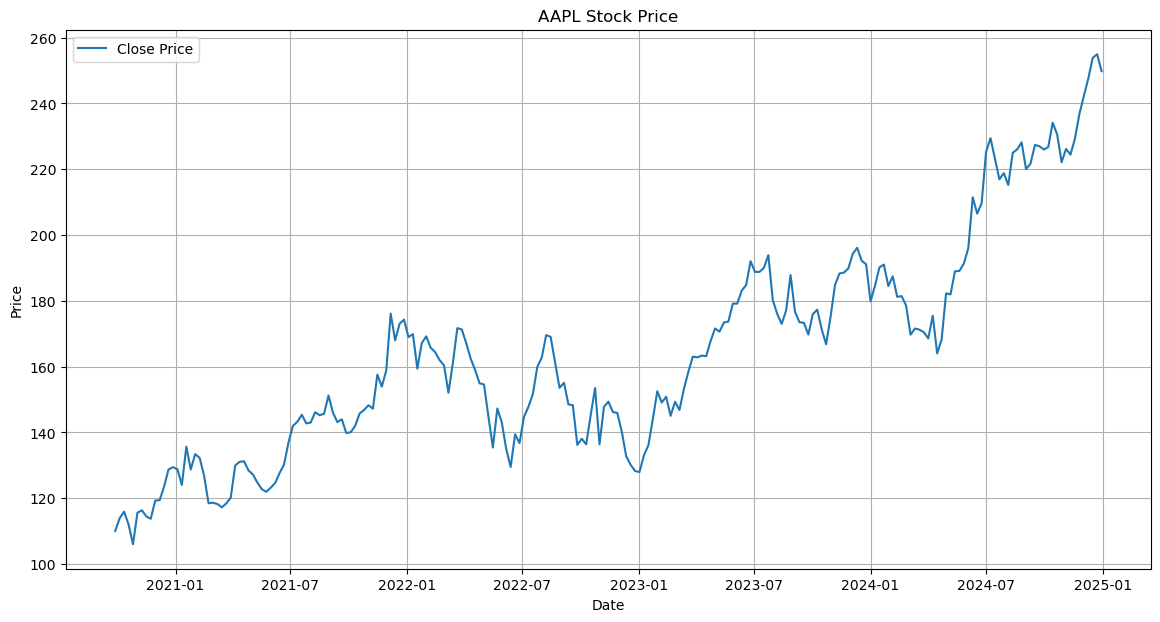

In [4]:
plot_data(data)
# Data visualisation using matplotlib and the seaborn libraries.

Also used various technical indicators as well while visualising the data, as it would be better to analyse it.

In [5]:
def MACD(data, short_window=12, long_window=26, signal_window=9):
    exp1 = data['Close'].ewm(span=short_window, adjust=False).mean()
    exp2 = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def Bollinger_Bands(data, window=20, num_std_dev=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, lower_band

In [6]:
def plot_technical_indicators(data):
    macd, signal = MACD(data)
    rsi = RSI(data)
    upper_band, lower_band = Bollinger_Bands(data)

    plt.figure(figsize=(14, 10))

    plt.subplot(3, 1, 1)
    plt.plot(data['Close'], label='Close Price')
    plt.plot(upper_band, label='Upper Band', linestyle='--')
    plt.plot(lower_band, label='Lower Band', linestyle='--')
    plt.title(f'{ticker} Bollinger Bands')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(macd, label='MACD', color='blue')
    plt.plot(signal, label='Signal Line', color='orange')
    plt.title('MACD')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(rsi, label='RSI', color='purple')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green')
    plt.title('RSI')
    plt.legend()

    plt.tight_layout()
    plt.show()

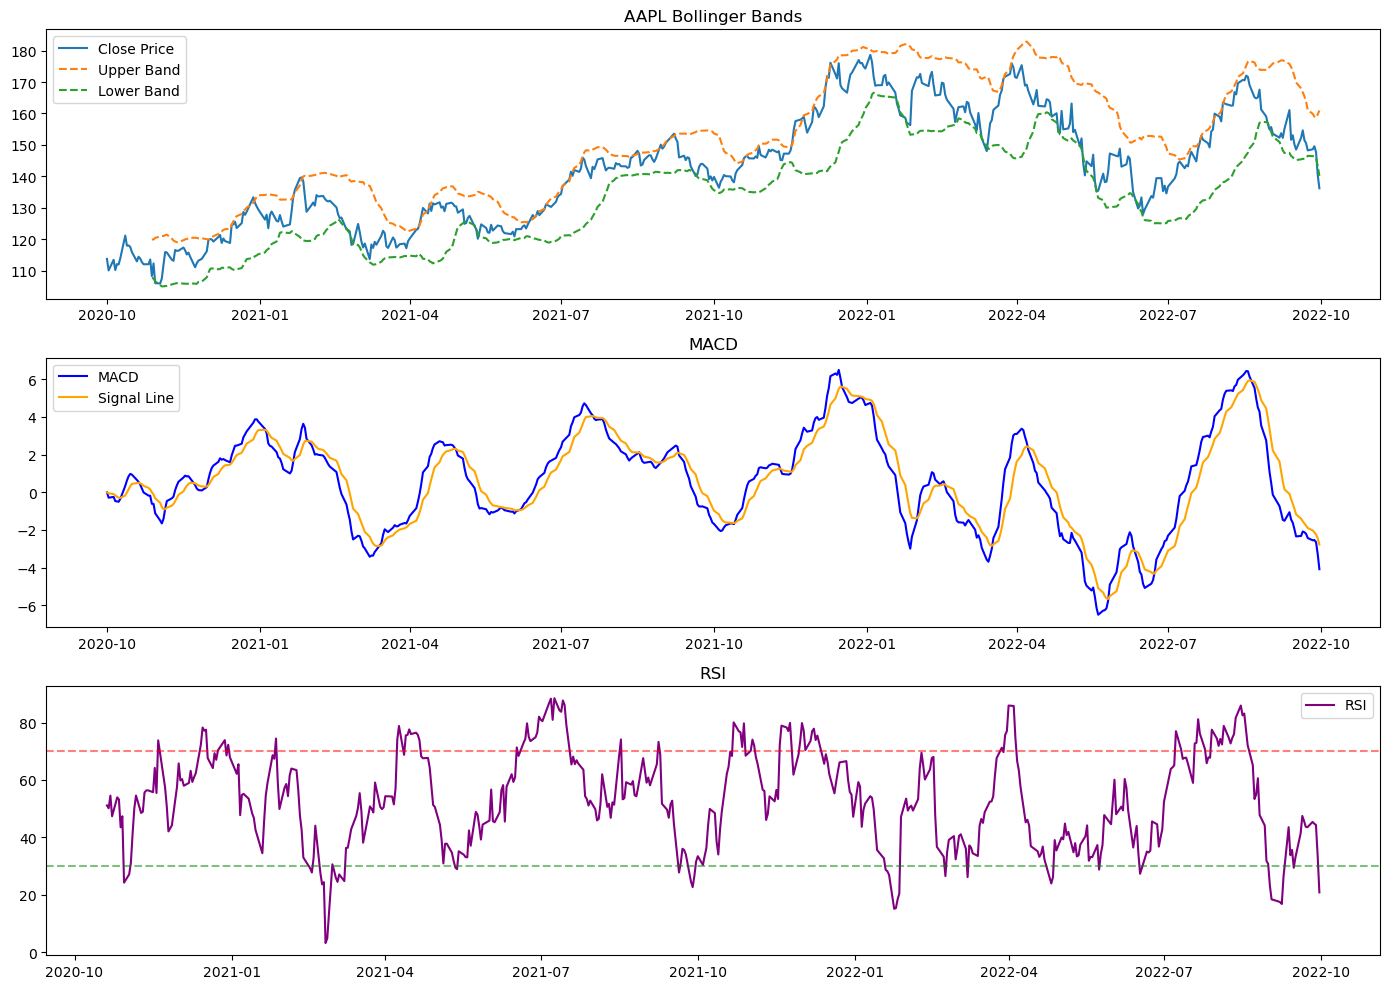

In [ ]:
plot_technical_indicators(data)
# Also used various technical indicators as well while visualising the data, as it would be better to analyse it.

Let us now build the LSTM model using tensorflow library.

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [8]:
model = create_lstm_model((data.shape[1], 1))
model.summary()

c:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Lets us now analyse the effectiveness of the following model using R2 MSME etc.

In [9]:
def R2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def MSME(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [10]:
print("R2:", R2(data['Close'].values, model.predict(data['Close'].values.reshape(-1, 1))))
print("MSME:", MSME(data['Close'].values, model.predict(data['Close'].values.reshape(-1, 1))))
# Lets us now analyse the effectiveness of the following model using R2 MSME etc.

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step
R2: -24.453032120380193
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MSME: 28055.482827071362


In [11]:
def prepare_data(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Prepare the data for LSTM
data_values = data['Close'].values.reshape(-1, 1)
X, y = prepare_data(data_values, time_step=60)
X = X.reshape((X.shape[0], X.shape[1], 1))
model.fit(X, y, epochs=50, batch_size=32)



Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 32104.5469
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 31306.2910
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 29701.8906
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 29943.8535
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 28350.6777
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 26596.8008
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 26271.6348
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 24713.5703
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 23612.3320
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 23079.7129
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 20701.5215
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 20008.6523
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 18918.9961
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 17205.8809
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33m